# Projekt 3 z metod numerycznych - badanie algorytmów interpolacji

autor: Stanisław Smykowski 184787

Kod potrzebny do przygotowania danych:

In [1]:
import csv
import matplotlib.pyplot as plt
import LagrangeInter
import SplineInter
import copy

def loadFileIntoVectors(fileName):
    file = open('./data/'+fileName+'.csv', 'r')
    loadedData = list(csv.reader(file))
    data = loadedData[1:]

    Y = []
    X = []

    for i in range(len(data)):
        X.append(float(data[i][0]))
        Y.append(float(data[i][1]))
    return X, Y

Przedstawienie wybranych profili wysokościowych na wykresach:

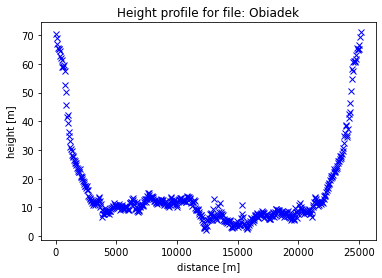

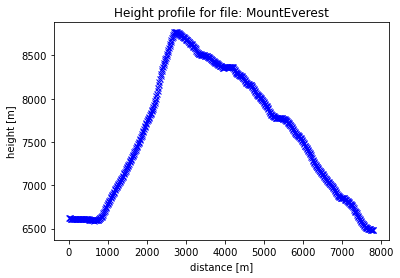

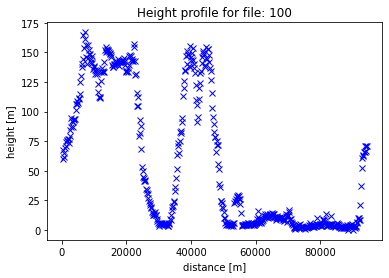

In [2]:
X1, Y1 = loadFileIntoVectors('Obiadek')
X2, Y2 = loadFileIntoVectors('MountEverest')
X3, Y3 = loadFileIntoVectors('100')
plt.plot(X1, Y1, 'bx')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.title('Height profile for file: Obiadek')
plt.show()

plt.plot(X2, Y2, 'bx')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.title('Height profile for file: MountEverest')
plt.show()

plt.plot(X3, Y3, 'bx')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.title('Height profile for file: 100')
plt.show()

Widzimy trzy profile wysokowościowe o trzech różnych charakterystykach. Jeden dość płaski, jeden z dużym wzniesieniem na środku oraz jeden z wieloma wzniesieniami.

Te dane będą służyły do badania funkcji interpolacji: metody splajnami oraz Lagrangea.

Kod zaimplementowachych algorytmów (wraz z fakoryzacją LU z poprzedniego projektu):

In [3]:
def LagrangeInter(X, Y):
    def f(x):
        result = 0
        n = len(X)
        for i in range(n):
            xi, yi = X[i], Y[i]
            base = 1
            for j in range(n):
                if i == j:
                    continue
                else:
                    xj, yj = X[j], Y[j]
                    base *= (float(x) - float(xj))/float(float(xi) - float(xj))
            result += float(yi) * base
        return result
    return f


def createOnesMatrix(N):
    result = []
    for i in range(N):
        row = []
        for j in range(N):
            if i == j:
                row.append(1)
            else:
                row.append(0)
        result.append(row)
    return result


def dotProduct(A, b):
    n = len(A)
    result = [0] * n
    for i in range(n):
        for j in range(n):
            result[i] += b[j] * A[i][j]
    return result


def luDecomposition(A):
    U = copy.deepcopy(A)
    L = createOnesMatrix(len(A))
    for k in range(0, len(A)):
        for j in range(k + 1, len(A)):
            L[j][k] = U[j][k] / U[k][k]
            for i in range(k, len(A)):
                U[j][i] = U[j][i] - L[j][k] * U[k][i]
    return L, U


def forwardSubstitution(L, b):
    n = len(L)
    x = [0] * n
    for i in range(0, n):
        value = b[i]
        for j in range(0, i):
            value -= L[i][j] * x[j]
        x[i] = value / L[i][i]
    return x


def backwardSubstitution(U, y):
    n = len(U)
    x = [0] * n
    for i in range(n - 1, -1, -1):
        value = y[i]
        for j in range(i, n):
            value -= U[i][j] * x[j]
        x[i] = value / U[i][i]
    return x


def luFactorization(A, b):
    L, U = luDecomposition(A)
    y = forwardSubstitution(L, b)
    x = backwardSubstitution(U, y)
    return x



def createZerosMatrix(m, n):
    result = []
    for i in range(m):
        row = [0] * n
        result.append(row)
    return result


def SplineInter(X, Y):
    def prepareEquations():
        n = len(X)
        mSize = 4 * (n - 1)
        A = createZerosMatrix(mSize, mSize)
        b = [0] * mSize

        # Si(xj) = f(xj)
        for i in range(n - 1):
            y = Y[i]
            row = [0] * mSize
            row[4 * i + 3] = 1  # a
            A[4 * i + 3] = row
            b[4 * i + 3] = (float(y))

        # Sj(Xj+1) = f(Xj+1)
        for i in range(n - 1):
            x1, y1 = X[i + 1], Y[i + 1]
            x0 = X[i]
            h = float(x1) - float(x0)
            row = [0] * mSize
            row[4 * i] = h ** 3         # d
            row[4 * i + 1] = h ** 2     # c
            row[4 * i + 2] = h ** 1     # b
            row[4 * i + 3] = 1          # a
            A[4 * i + 2] = row
            b[4 * i + 2] = float(y1)

        # for inner points, Sj-1'(xj) = Sj'(xj)
        for i in range(n - 2):
            x1 = X[i + 1]
            x0 = X[i]
            h = float(x1) - float(x0)
            row = [0] * mSize
            row[4 * i] = 3 * (h ** 2)   # d
            row[4 * i + 1] = 2 * h      # c
            row[4 * i + 2] = 1          # b0
            row[4 * (i + 1) + 2] = -1   # b1
            A[4 * i] = row
            b[4 * i] = float(0)

        # for inner points, Sj-1''(xj) = Sj''(xj)
        for i in range(n - 2):
            x1 = X[i + 1]
            x0 = X[i]
            h = float(x1) - float(x0)
            row = [0] * mSize
            row[4 * i] = 6 * h          # d
            row[4 * i + 1] = 2          # c0
            row[4 * (i + 1) + 1] = -2   # c1
            A[4 * (i + 1) + 1] = row
            b[4 * (i + 1) + 1] = float(0)

        # S0''(x0) = 0
        row = [0] * mSize
        row[1] = 1          # c0
        A[1] = row
        b[1] = float(0)

        # Sn-1''(xn-1) = 0
        row = [0] * mSize
        x1 = X[-1]
        x0 = X[-2]
        h = float(x1) - float(x0)
        row[1] = 2          # c
        row[-4] = 6 * h     # d
        A[-4] = row
        b[-4] = float(0)

        result = luFactorization(A, b)
        return result

    params = prepareEquations()

    def f(x):
        param_array = []
        row = []
        for param in params:
            row.append(param)
            if len(row) == 4:
                param_array.append(row.copy())
                row.clear()

        for i in range(1, len(X)):
            xi, yi = X[i - 1], Y[i - 1]
            xj, yj = X[i], Y[i]
            if float(xi) <= x <= float(xj):
                a, b, c, d = param_array[i-1]
                h = x - float(xi)
                return a*(h**3)+b*(h**2)+c*h+d

        return yj

    return f

Metoda Lagrangea:

Teraz przystąpię do badania metody Lagrangea.

Wpierwszej kolejności dzielę punkty funcji wejściowej na odcinki o długości 20 i interpoluję dla trzech plików:

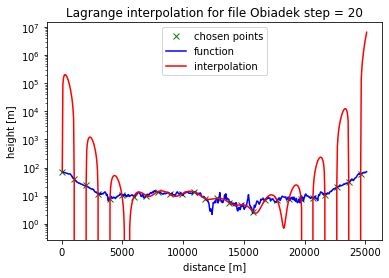

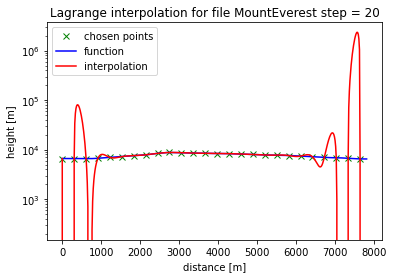

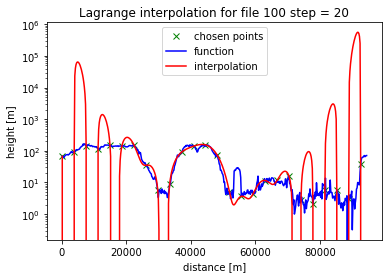

In [4]:
X, Y = loadFileIntoVectors('Obiadek')
dataToInterX = X[0::20]
dataToInterY = Y[0::20]

F = LagrangeInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Lagrange interpolation for file Obiadek step = 20')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()


X, Y = loadFileIntoVectors('MountEverest')
dataToInterX = X[0::20]
dataToInterY = Y[0::20]

F = LagrangeInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Lagrange interpolation for file MountEverest step = 20')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()


X, Y = loadFileIntoVectors('100')
dataToInterX = X[0::20]
dataToInterY = Y[0::20]

F = LagrangeInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Lagrange interpolation for file 100 step = 20')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()

Widać, że ta metoda dość dobrze zachowuje się w środkowej części funkcji, ale na krańcach pojawia się duże wachanie i odbieganie od rzeczywistych wartości. Szczególnie widać to w funkcji z jednym wzniesieniem. Nazwywa się to efektem Rungego. Sprawdzę teraz jaki będzie wynik gdy zwiększę ilość punktów przekazywanych do metody.

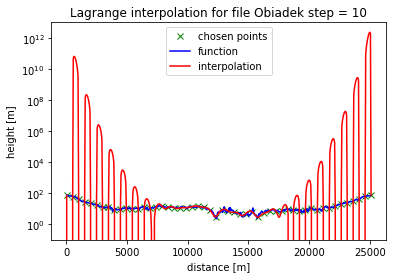

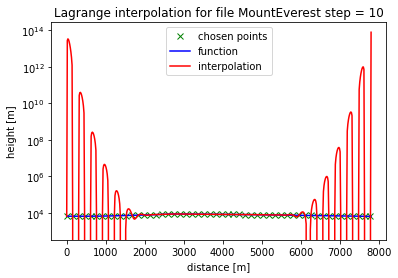

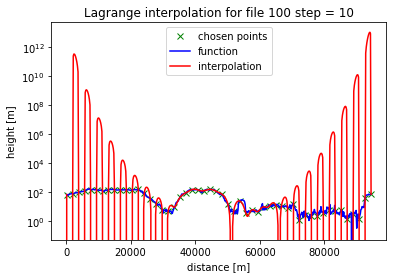

In [5]:
X, Y = loadFileIntoVectors('Obiadek')
dataToInterX = X[0::10]
dataToInterY = Y[0::10]

F = LagrangeInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Lagrange interpolation for file Obiadek step = 10')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()


X, Y = loadFileIntoVectors('MountEverest')
dataToInterX = X[0::10]
dataToInterY = Y[0::10]

F = LagrangeInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Lagrange interpolation for file MountEverest step = 10')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()


X, Y = loadFileIntoVectors('100')
dataToInterX = X[0::10]
dataToInterY = Y[0::10]

F = LagrangeInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Lagrange interpolation for file 100 step = 10')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()

Widać, że efekt Rungego nawet się wzmocnił. Spróbuję teraz zmniejszyć ilość punktów.

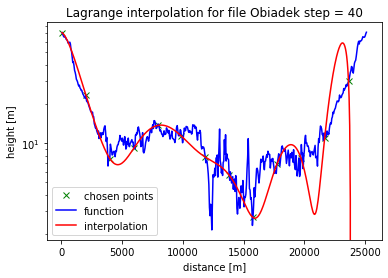

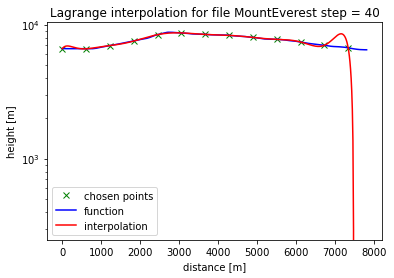

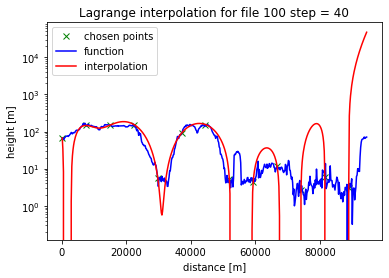

In [6]:
X, Y = loadFileIntoVectors('Obiadek')
dataToInterX = X[0::40]
dataToInterY = Y[0::40]

F = LagrangeInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Lagrange interpolation for file Obiadek step = 40')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()


X, Y = loadFileIntoVectors('MountEverest')
dataToInterX = X[0::40]
dataToInterY = Y[0::40]

F = LagrangeInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Lagrange interpolation for file MountEverest step = 40')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()


X, Y = loadFileIntoVectors('100')
dataToInterX = X[0::40]
dataToInterY = Y[0::40]

F = LagrangeInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Lagrange interpolation for file 100 step = 40')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()

Choć efekt Rungego zmalał, i w niektórych przedziałach można uznać interpolację tą metodą za wystarczająco udaną, to nadal wyniki nie są zbyt zadowalające.
Widać, że zmniejszanie ilośći punktów pomaga zmniejszyć efekt Rungego, ale zmniejsza też dokładność interpolacji. Ta metoda może być używana tylko po odrzuceniu pewnej części wyników na początku i na końcu funkcji.

Metoda interpolacji splajnami:

Ta metoda nosi też nazwę interpolacji funkcjami sklejanymi trzeciego stopnia. Przygotuję wykresy dla tych samych plików i tych samych długości przedziałów co w poprzedniej metodzie.

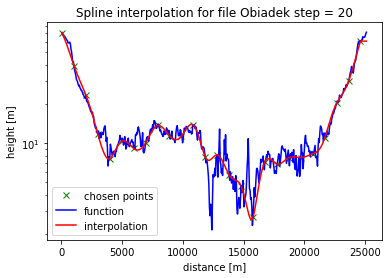

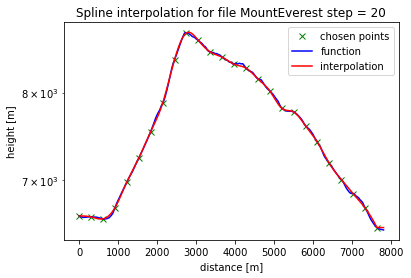

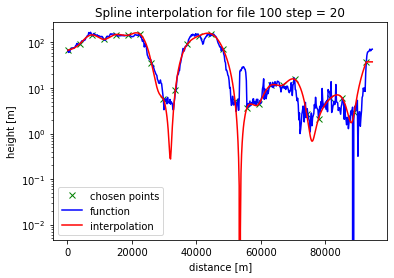

In [7]:
X, Y = loadFileIntoVectors('Obiadek')
dataToInterX = X[0::20]
dataToInterY = Y[0::20]

F = SplineInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Spline interpolation for file Obiadek step = 20')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()


X, Y = loadFileIntoVectors('MountEverest')
dataToInterX = X[0::20]
dataToInterY = Y[0::20]

F = SplineInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Spline interpolation for file MountEverest step = 20')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()


X, Y = loadFileIntoVectors('100')
dataToInterX = X[0::20]
dataToInterY = Y[0::20]

F = SplineInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Spline interpolation for file 100 step = 20')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()

Dla takich samych przedziałów wyniki nie są szczególnie dokładne. Nie widać natomiast efekty Rungego. Zwiększę ilość punktów jak poprzednio.

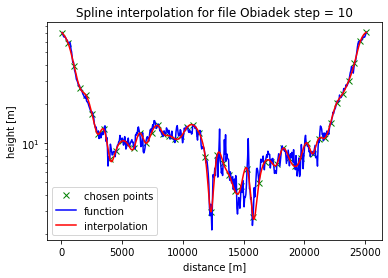

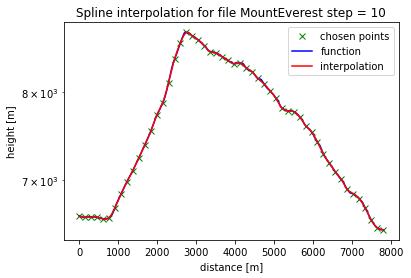

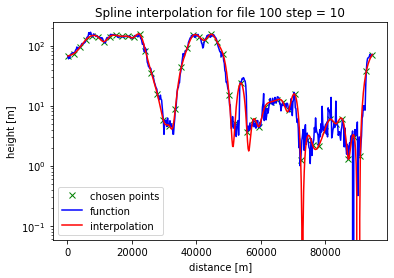

In [8]:
X, Y = loadFileIntoVectors('Obiadek')
dataToInterX = X[0::10]
dataToInterY = Y[0::10]

F = SplineInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Spline interpolation for file Obiadek step = 10')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()


X, Y = loadFileIntoVectors('MountEverest')
dataToInterX = X[0::10]
dataToInterY = Y[0::10]

F = SplineInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Spline interpolation for file MountEverest step = 10')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()


X, Y = loadFileIntoVectors('100')
dataToInterX = X[0::10]
dataToInterY = Y[0::10]

F = SplineInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Spline interpolation for file 100 step = 10')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()

W zasadzie dla wszystkich profili dokładność wyniku poprawiła się. Nie widać efektu Rungego. Miejscami jednak wyniki odbiega od funkcji.
Wykresy dla majmniejszej ilośći punktów:

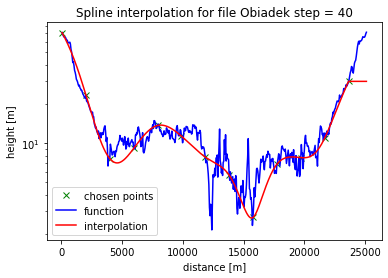

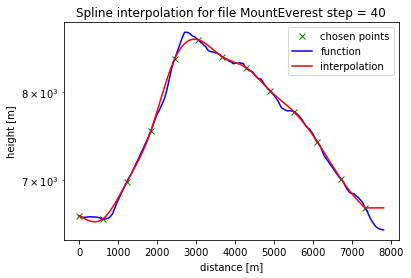

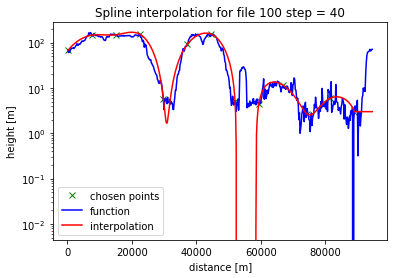

In [9]:
X, Y = loadFileIntoVectors('Obiadek')
dataToInterX = X[0::40]
dataToInterY = Y[0::40]

F = SplineInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Spline interpolation for file Obiadek step = 40')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()


X, Y = loadFileIntoVectors('MountEverest')
dataToInterX = X[0::40]
dataToInterY = Y[0::40]

F = SplineInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Spline interpolation for file MountEverest step = 40')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()


X, Y = loadFileIntoVectors('100')
dataToInterX = X[0::40]
dataToInterY = Y[0::40]

F = SplineInter(dataToInterX, dataToInterY)
interY = []
for point in X:
    interY.append(float(F(point)))

plt.semilogy(dataToInterX, dataToInterY, 'gx', label='chosen points')
plt.semilogy(X, Y, 'b-', label='function')
plt.semilogy(X, interY, 'r-', label='interpolation')
plt.title('Spline interpolation for file 100 step = 40')
plt.xlabel('distance [m]')
plt.ylabel('height [m]')
plt.legend()
plt.show()

W tym wypadku wynik znacząco odbiega od funkcji. Zbyt mała ilość punktów nie pozwala uzyskać dokładnej interpolacji. Używając jednak metody splajnami możemy swobodnie zwiększać ilość punktów bez obawy o wystąpienie efektu Rungego.

Wnioski:

Obydwie metody działają w pewnym zakresie. Metoda splajnami jest bardziej złożona obliczeniowo i wymaga więcej czasu, ale daje wyniki bardziej zadowalające. Pozostawia możliwość zwiększania ilośći punktów pomiarowych bez strat dokładnośći na krańcach badanej funkcji. Metoda Lagrangea natomiast nie jest pozbawiona tej wady. Korzystając z niej w zasadzie trzeba znaleźć złoty środek ilości punktów tak, aby efekt Rungego nie był zbyt duży, a wynik wystarczająco dokładny.